# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [92]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tools.eval_measures
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
print(sensor.shape)
sensor.head()

(1751, 12)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [10]:
sensor[sensor.isnull()].count()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

*Don't seem to be any missing data.*

How many rows and columns are in our data?

In [15]:
print(f'{sensor.shape[0]} rows and {sensor.shape[1]} columns')

1751 rows and 12 columns


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [44]:
datetime = pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=1751)

pandas.core.indexes.datetimes.DatetimeIndex

Assign the time series index to the dataframe's index.

In [57]:
#Aquí he metido datetime como DatetimeIndex como hizo Marc, pero creo que es redundante, porque datetime
# es ya tipo DatetimeIndex

sensor.index=pd.DatetimeIndex(datetime, freq='infer')
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

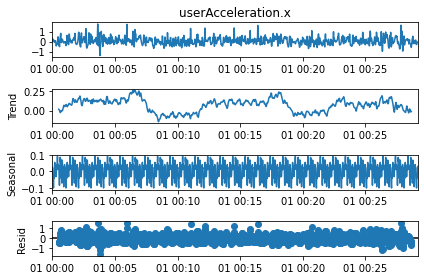

In [58]:
sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], period=60).plot()
print('')

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

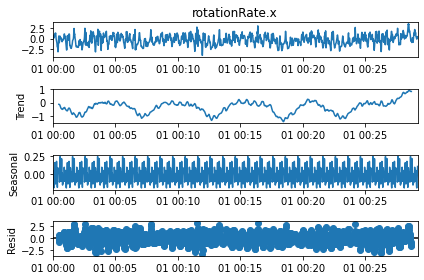

In [59]:
sm.tsa.seasonal_decompose(sensor['rotationRate.x'], period=60).plot()
print('')

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

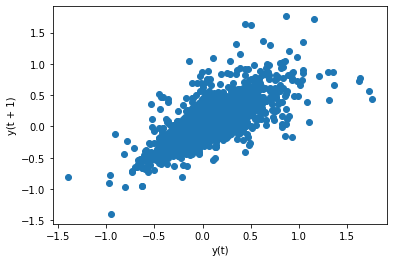

In [60]:
pd.plotting.lag_plot(sensor['userAcceleration.x'])


Create a lag plot for `rotationRate.x`

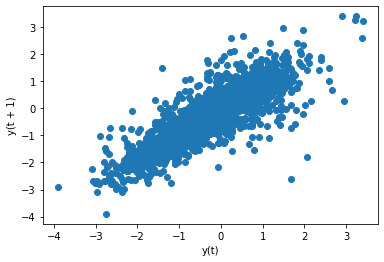

In [61]:
pd.plotting.lag_plot(sensor['rotationRate.x'])



What are your conclusions from both visualizations?

*Lag plots are used to check whether a time series is generated by a random process or not. When plotting a data point against the next one, one can check for visible patterns in the data. No patterns at all means the data is random. Other patterns suggest some correlation with itself (autocorrelation). In this case, we observe some linear pattern for both variables, stronger for the rotation at x. This suggest that there is an autocorrelation and autoregression models might be appropiate to predict the data.*

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [62]:
test, pval, lag, n, crit_val, AIC = sm.tsa.stattools.adfuller(sensor['userAcceleration.x'])
print(f'With a pvalue of {round(pval,5)}, we reject the null hypothesis, data is stationary')

With a pvalue of 0.0, we reject the null hypothesis, data is not stationary


In [63]:
test, pval, lag, n, crit_val, AIC = sm.tsa.stattools.adfuller(sensor['rotationRate.x'])
print(f'With a pvalue of {round(pval,5)}, we reject the null hypothesis, data is stationary')

With a pvalue of 1e-05, we reject the null hypothesis, data is not stationary


What are your conclusions from this test?

*Both variables are stationary time series. This is, they are stationary over time, thei're statistical values does not change over time. In other words, there is not a time dependent proccess in the data.*


*I will now do the same but using the cool class definition from the link that Clara provided, just to keep the class somwhere for the future :)*

In [229]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [230]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(sensor['userAcceleration.x'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.795799e+01
P-Value                 2.823439e-30
# Lags Used             4.000000e+00
# Observations Used     1.746000e+03
Critical Value (1%)    -3.434101e+00
Critical Value (5%)    -2.863197e+00
Critical Value (10%)   -2.567652e+00
dtype: float64
Is the time series stationary? True


In [231]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(sensor['rotationRate.x'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -5.269861
P-Value                    0.000006
# Lags Used               25.000000
# Observations Used     1725.000000
Critical Value (1%)       -3.434147
Critical Value (5%)       -2.863217
Critical Value (10%)      -2.567663
dtype: float64
Is the time series stationary? True


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [233]:
train = sensor['userAcceleration.x'][:1741]
test = sensor['userAcceleration.x'][1741:]
model = sm.tsa.ARMA(train, order=(2,1))
arma_results = model.fit()
y_pred = arma_results.predict(start=len(train),end=len(train)+len(test)-1, dynamic=False)

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [234]:
statsmodels.tools.eval_measures.rmse(y_pred, test)

0.22529863653820809

*That's a very high value considering the scale of the data. We can actually see how bad the predictions are comparing predicted and real values:*

In [235]:
results = pd.DataFrame({
    "ground_truth":test,
    "prediction":y_pred,
    "difference":y_pred-test
})
results

,ground_truth,prediction,difference
2018-01-01 00:29:01,0.149749,0.173149,0.023400
2018-01-01 00:29:02,0.038461,0.142896,0.104435
2018-01-01 00:29:03,-0.169175,0.100522,0.269697
2018-01-01 00:29:04,-0.300361,0.070106,0.370467
2018-01-01 00:29:05,-0.270174,0.056099,0.326273
2018-01-01 00:29:06,-0.268367,0.053778,0.322145
2018-01-01 00:29:07,-0.102444,0.056790,0.159234
2018-01-01 00:29:08,-0.085590,0.060646,0.146236
2018-01-01 00:29:09,-0.048105,0.063316,0.111421
2018-01-01 00:29:10,-0.065011,0.064493,0.129504


## BONUS: Apply a low pass filter to the data

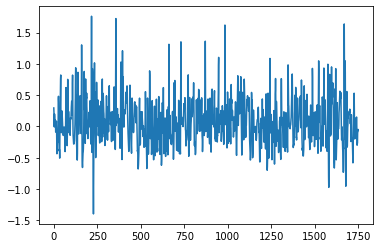

In [201]:
data = list(sensor['userAcceleration.x'])
plt.plot(data)

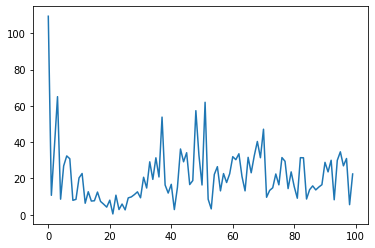

In [245]:
fourier = np.abs(fft(data))
plt.plot(fourier[:100])

In [255]:
#Cortamos a frequencia cinco
5/1750

0.002857142857142857

In [264]:
#No entiendo estos valores, los he ido cambiando hasta visualizar la curva que quería...
b, a = signal.butter(3, 0.002)

data_clean = signal.filtfilt(b, a, data)

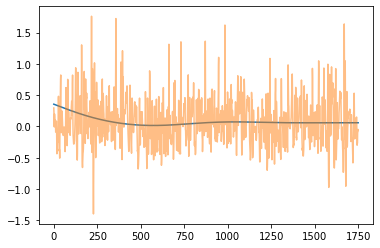

In [265]:
plt.plot(data_clean)
plt.plot(data, alpha=0.5)

*ARMA models are design to test data series with seasonality. When applying the low pass, I have eliminated the slight seasonality of the data and the ARMA model cannot be applied. I will apply the AR model instead (actually, I will use AutoReg, since AR is deprecated)*

In [258]:
train =data_clean[:1741]
test = data_clean[1741:]
#4 lags yield the lowest mse value
model = sm.tsa.AutoReg(train, lags = 4)
fit_model = model.fit()

In [259]:
y_pred = fit_model.predict(start=len(train),end=len(train)+len(test)-1, dynamic=False)
statsmodels.tools.eval_measures.rmse(y_pred, test)

3.6271440072576684e-08

In [260]:
results = pd.DataFrame({
    "ground_truth":test,
    "prediction":y_pred,
    "difference":y_pred-test
})
results

,ground_truth,prediction,difference
0,0.05853,0.058530,-1.200893e-10
1,0.05853,0.058530,-5.996967e-10
2,0.05853,0.058530,-1.796834e-09
3,0.05853,0.058530,-4.187334e-09
4,0.05853,0.058530,-8.364085e-09
5,0.05853,0.058530,-1.503627e-08
6,0.05853,0.058530,-2.502864e-08
7,0.05853,0.058530,-3.928076e-08
8,0.05853,0.058529,-5.884628e-08
9,0.05853,0.058529,-8.489225e-08



*Since rotation rate is more seasonal, it makes more sense to use an ARMA to fit it:*

In [266]:
data = list(sensor['rotationRate.x'])

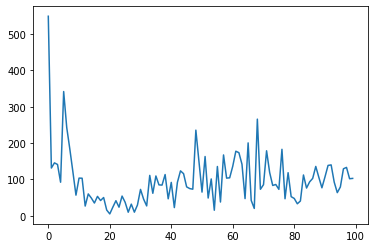

In [268]:
fourier = np.abs(fft(data))
plt.plot(fourier[:100])

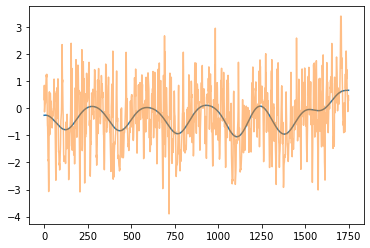

In [296]:
b, a = signal.butter(3, 0.01)
data_clean = signal.filtfilt(b, a, data)
plt.plot(data_clean)
plt.plot(data, alpha=0.5)

In [286]:
train =data_clean[:1741]
test = data_clean[1741:]
model = sm.tsa.ARMA(train, order=(0,1))
arma_results = model.fit()
y_pred = arma_results.predict(start=len(train),end=len(train)+len(test)-1, dynamic=False)


*I could only fit it using order 0,1. I think, because I am using such a low order, predicted values are constant from the second predicted on. Maybe there are not enough pattern repetition to fit the model?*

In [287]:
statsmodels.tools.eval_measures.rmse(y_pred, test)

1.0134458603756764

In [288]:
results = pd.DataFrame({
    "ground_truth":test,
    "prediction":y_pred,
    "difference":y_pred-test
})
results

,ground_truth,prediction,difference
0,0.743270,0.213264,-0.530006
1,0.741190,-0.318149,-1.059339
2,0.739311,-0.318149,-1.057460
3,0.737630,-0.318149,-1.055779
4,0.736138,-0.318149,-1.054287
5,0.734829,-0.318149,-1.052978
6,0.733692,-0.318149,-1.051841
7,0.732718,-0.318149,-1.050867
8,0.731896,-0.318149,-1.050045
9,0.731213,-0.318149,-1.049362
